In [102]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model

import os
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.utils import plot_model, to_categorical

import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import SGD
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from PIL import Image

In [15]:
gpu = tf.config.list_physical_devices('GPU')[0]
try:
    tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpu), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:
    print(e)
    
# Random seed
seed = 54
np.random.seed(seed)
tf.random.set_seed(seed)

2 Physical GPUs, 1 Logical GPUs


In [16]:
##############################################################################
######################  Declaración de variables #############################
##############################################################################

# Semilla de números alearorios 
seed = 45
np.random.seed(seed)

# Dimensiones de las imagenes RGB.
IMG_WIDTH = 200
IMG_HEIGHT = 200
IMG_CHANNELS = 3

##############################################################################
############################  Path Base  #####################################
##############################################################################

BASE_PATH = str(os.path.dirname(os.path.abspath(''))) # path del la carpeta Segmentacion Semantica Git

if ('\\' in BASE_PATH) == True:
    separator_dir = '\\'
else:
    separator_dir = '/'
    
    
##############################################################################
####################  Augmented path ############################
##############################################################################

# Path de las imagenes, mascaras e imagenes de prueba
TRAIN_PATH_IMAGES = BASE_PATH + separator_dir + 'Augmented Train Data' + separator_dir + 'Images'
TRAIN_PATH_MASKS = BASE_PATH + separator_dir + 'Augmented Train Data' + separator_dir + 'Masks'

## Preprocess the augmented images

In [57]:
# Se obtienen los Ids de las imagenes aumentadas.
Train_images_files = next(os.walk(TRAIN_PATH_IMAGES))[2]
Train_masks_files = next(os.walk(TRAIN_PATH_MASKS))[2]



# Se declaran los arrays que almacenan las imagenes
X_train = np.zeros((len(Train_images_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(Train_images_files), IMG_HEIGHT, IMG_WIDTH,1), dtype=np.bool)
Y_train_class = np.zeros((len(Train_images_files), 1), dtype=np.uint8)


# Se inicia el proceso de resizing de las imagenes de entrenamiento y las de prueba
print('Resizing images')

for n, id_ in tqdm(enumerate(Train_images_files), total=len(Train_images_files)):
    path_image = TRAIN_PATH_IMAGES + '\\'
    path_mask = TRAIN_PATH_MASKS + '\\'
    img = imread(path_image + Train_images_files[n])[:,:,:IMG_CHANNELS]
    X_train[n] = img
    
    mask = imread(path_mask + Train_masks_files[n])
    mask = np.expand_dims(mask, axis=-1)
    Y_train[n] = mask
    X_train[n] = X_train[n]*Y_train[n]
    
    name = id_[:5]
    if name == 'N_C_F':
        Y_train_class[n] = 1
    if name == 'N_C_S':
        Y_train_class[n] = 2

    if name == 'N_C_T':
        Y_train_class[n] = 3

    if name == 'N_S_S':
        Y_train_class[n] = 0
Y_train_class = to_categorical(Y_train_class, num_classes=4)       

    # if name == 'N_C_F':
    #     Y_train_class[n,0] = 1
    #     Y_train_class[n,1] = 0
    #     Y_train_class[n,2] = 0
    #     Y_train_class[n,3] = 0
    # if name == 'N_C_S':
    #     Y_train_class[n,0] = 0
    #     Y_train_class[n,1] = 1
    #     Y_train_class[n,2] = 0
    #     Y_train_class[n,3] = 0
    # if name == 'N_C_T':
    #     Y_train_class[n,0] = 0
    #     Y_train_class[n,1] = 0
    #     Y_train_class[n,2] = 1
    #     Y_train_class[n,3] = 0
    # if name == 'N_S_S':
    #     Y_train_class[n,0] = 0
    #     Y_train_class[n,1] = 0
    #     Y_train_class[n,2] = 0
    #     Y_train_class[n,3] = 1    





# Es necesario organizar de forma aleatoria el dataset aumentado para un correcto entrenamiento del modelo
index = np.arange(X_train.shape[0])
np.random.shuffle(index)


X = X_train[index]
X_train = []
Y = Y_train_class[index]
Y_train_class = []

  1%|▊                                                                              | 38/3998 [00:00<00:20, 191.00it/s]

Resizing train images


100%|█████████████████████████████████████████████████████████████████████████████| 3998/3998 [00:16<00:00, 235.72it/s]


In [58]:
train_percentage = 0.9
X_train = X[0:round(train_percentage*len(X))]
Y_train = Y[0:round(train_percentage*len(Y))]
X_test = X[round(train_percentage*len(X))::]
Y_test = Y[round(train_percentage*len(Y))::]
X = []
Y = []

## Loading VGG16 for Transfer Learning

We need to load the pre-trained model which is the VGG16. VGG16 is a convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”. More information about this network can be found here: https://neurohive.io/en/popular-networks/vgg16/. The VGG16 layers trainable attribute was set to False because we only wish to train the last layers that will later be added to the network.

In [59]:
pre_trained_model = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
pre_trained_model.trainable = False

#pre_trained_model = InceptionV3(input_shape = (image_size, image_size, 3), include_top = False)
#for layer in pre_trained_model.layers:
#    layer.trainable = False

In [60]:
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

## Training Process

We added the dense layers needed in order train our model:

In [69]:
#last_layer = pre_trained_model.get_layer('mixed9')
#last_output = last_layer.output

last_output = pre_trained_model.output

x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(4, activation = 'softmax')(x)



model = Model(pre_trained_model.input, x)
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['acc'])
model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0  

In [70]:
history = model.fit(X_train,
                    Y_train,
                    validation_data = (X_test, Y_test),
                    batch_size=8,
                    epochs=10)

Epoch 1/10
450/450 [==============================] - 31s 68ms/step - loss: 14.2186 - acc: 0.5865 - val_loss: 0.7769 - val_acc: 0.7675
Epoch 2/10
450/450 [==============================] - 35s 77ms/step - loss: 0.4358 - acc: 0.8551 - val_loss: 0.5874 - val_acc: 0.8100
Epoch 3/10
450/450 [==============================] - 39s 88ms/step - loss: 0.3847 - acc: 0.8966 - val_loss: 0.9458 - val_acc: 0.7625
Epoch 4/10
450/450 [==============================] - 38s 85ms/step - loss: 0.2507 - acc: 0.9180 - val_loss: 0.8088 - val_acc: 0.8300
Epoch 5/10
450/450 [==============================] - 38s 84ms/step - loss: 0.2890 - acc: 0.9348 - val_loss: 1.2567 - val_acc: 0.7925
Epoch 6/10
450/450 [==============================] - 40s 90ms/step - loss: 0.4987 - acc: 0.9068 - val_loss: 1.3241 - val_acc: 0.7925
Epoch 7/10
450/450 [==============================] - 39s 86ms/step - loss: 0.2976 - acc: 0.9258 - val_loss: 0.6298 - val_acc: 0.8650
Epoch 8/10
450/450 [==============================] - 42s 94m

## Plotting training and validation curves

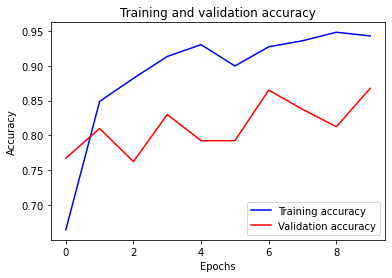

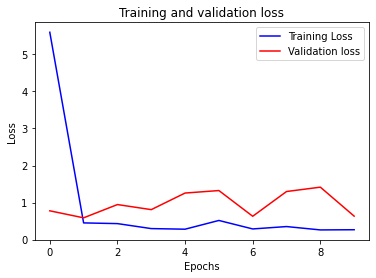

In [82]:
def plot(history):
    acc = history.history['acc']
    acc_validation = history.history['val_acc']
    loss = history.history['loss']
    loss_validation = history.history['val_loss']
    epochs = range(len(acc))
    
    plt.plot(epochs, acc, 'b', label = 'Training accuracy')
    plt.plot(epochs, acc_validation, 'r', label = 'Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc='best')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    plt.figure()
    
    plt.plot(epochs, loss, 'b', label = 'Training Loss')
    plt.plot(epochs, loss_validation, 'r', label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.legend(loc='best')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
plot(history)

## Plot Confussion Matrix

In [166]:
def graficarMatrizConfusion(y_true, y_pred):
    labels = ['Cracks', 'Shadows', 'Dust', 'WF']

    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') #/ cm.sum(axis=1)[:, np.newaxis]  

    fig = plt.figure(figsize=(8,8))

    ax = sns.heatmap(cm, annot = True, cbar = True);
      
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.set_xticklabels(labels)
    ax.set_yticks([0.5, 1.5, 2.5, 3.5])
    ax.set_yticklabels(labels)
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.title("Confussion Matrix")
    plt.savefig(str(os.path.dirname(os.path.abspath('')))+ '/img/Confussion_matrix.png')
    plt.show()

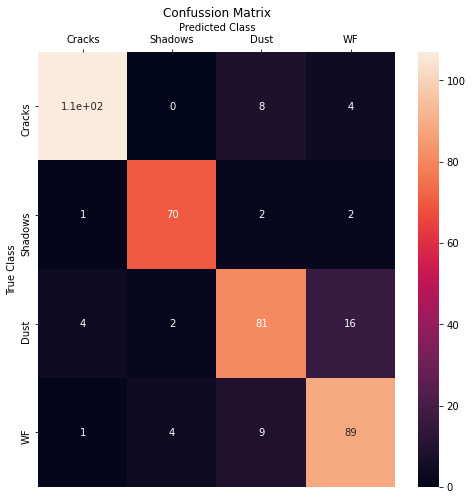

In [167]:
graficarMatrizConfusion(y_true = np.argmax(Y_test, axis = 1), y_pred = np.argmax(model.predict(X_test),axis=1))

## Save Created Model

In [168]:
models_folder = os.path.dirname(os.path.dirname(os.path.abspath(''))) + "/models"
model.save(models_folder + '/transfer_learning_quat_classification_model.h5')